In [1]:
import gc 
import numpy as np # linear algebra
from numpy import hstack
from numpy import array
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Definitions
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', 100)    #Display upto 100 columns 
pd.set_option('display.max_rows', 100) 
%matplotlib inline

# Check the files available in the directory
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')     


In [2]:
import os
import pandas as pd
HOUSING_PATH = os.path.join("..", "input", "zillow-prize-1")
PROPERTIES_2016 = '/home/wangyipeng/ysy1/DeepGBM-master/experiments/data/zillow/properties_2016.csv'
PROPERTIES_2017 = '/home/wangyipeng/ysy1/DeepGBM-master/experiments/data/zillow/properties_2017.csv'
TRAIN_2016 = '/home/wangyipeng/ysy1/DeepGBM-master/experiments/data/zillow/train_2016_v2.csv'
TRAIN_2017 = '/home/wangyipeng/ysy1/DeepGBM-master/experiments/data/zillow/train_2017.csv'
a=pd.read_csv('/home/wangyipeng/ysy1/DeepGBM-master/experiments/data/zillow/properties_2016.csv')  
b=pd.read_csv('/home/wangyipeng/ysy1/DeepGBM-master/experiments/data/zillow/properties_2017.csv')
print(a.shape,b.shape)
# (90275, 3) (77613, 3)
# (2985217, 58) (2985217, 58)
def load_housing_data(housing_path=HOUSING_PATH):
    properties_2016 = pd.read_csv(os.path.join(housing_path, PROPERTIES_2016))
    properties_2017 = pd.read_csv(os.path.join(housing_path, PROPERTIES_2017))
    train_2016 = pd.read_csv(os.path.join(housing_path, TRAIN_2016))
    train_2017 = pd.read_csv(os.path.join(housing_path, TRAIN_2017))

    # Left join will ignore all properties that do not have a logerror (target variable) associated with them
    train_2016 = pd.merge(train_2016, properties_2016, how = 'left', on = 'parcelid')
    train_2017 = pd.merge(train_2017, properties_2017, how = 'left', on = 'parcelid')
    
    # Union data for 2016 and 2017 into one dataframe
    all_properties = pd.concat([properties_2016, properties_2017], ignore_index=True)
    all_training = pd.concat([train_2016, train_2017], ignore_index=True)
    return all_properties, all_training


(2985217, 58) (2985217, 58)


In [3]:
all_properties, housing = load_housing_data()
# housing.head()
housing.shape

(167888, 60)

In [4]:
print("Total Properties Shape: {}".format(all_properties.shape))
print("-"*50)
housing.info()

Total Properties Shape: (5970434, 58)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      167888 non-null  int64  
 1   logerror                      167888 non-null  float64
 2   transactiondate               167888 non-null  object 
 3   airconditioningtypeid         53788 non-null   float64
 4   architecturalstyletypeid      468 non-null     float64
 5   basementsqft                  93 non-null      float64
 6   bathroomcnt                   167854 non-null  float64
 7   bedroomcnt                    167854 non-null  float64
 8   buildingclasstypeid           31 non-null      float64
 9   buildingqualitytypeid         107173 non-null  float64
 10  calculatedbathnbr             166056 non-null  float64
 11  decktypeid     

In [5]:
# Check for and drop duplicates in training dataset
def check_duplicates(housing): 
    idsUnique = len(housing[['parcelid', 'transactiondate']].value_counts())
    idsTotal = housing.shape[0]
    idsDupli = idsTotal - idsUnique
    print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")
    
def drop_duplicates(housing):
    # Drop all duplicate entries which have the same parcelID and Transaction Date
    print("Dropping all duplicates based on parcelid and transactiondate...")
    return housing.drop_duplicates(subset=['parcelid', 'transactiondate'], keep='last', ignore_index=True) 

In [6]:
# Check for and drop duplicates
check_duplicates(housing)
housing = drop_duplicates(housing)

# Validate 
check_duplicates(housing)

There are 0 duplicate IDs for 167888 total entries
Dropping all duplicates based on parcelid and transactiondate...
There are 0 duplicate IDs for 167888 total entries


In [7]:
y = housing.logerror

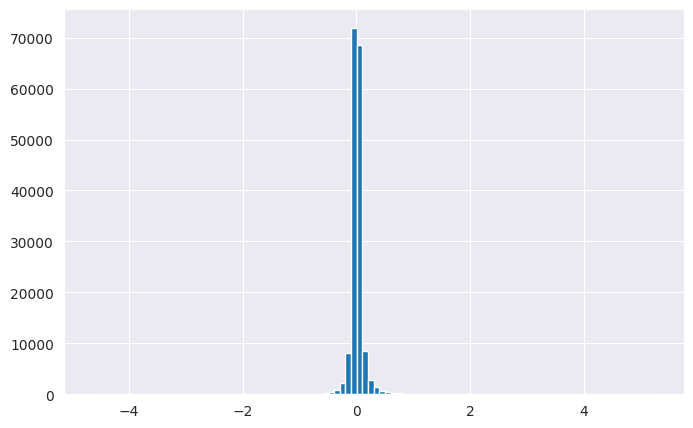

In [8]:
y.hist(bins=100, figsize=(8,5))
plt.show()

In [9]:
y.describe()

count   167888.000
mean         0.014
std          0.166
min         -4.655
25%         -0.025
50%          0.006
75%          0.039
max          5.263
Name: logerror, dtype: float64


 mu = 0.01 and sigma = 0.17



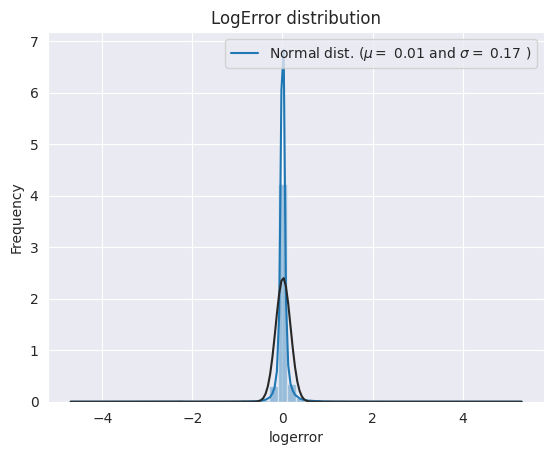

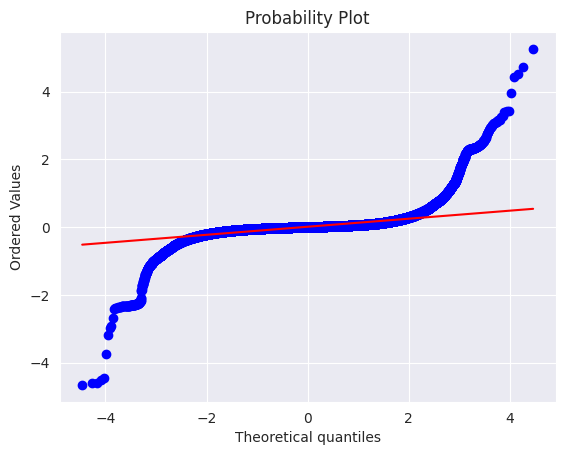

In [10]:
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

In [11]:
highest_thres = y.mean() + 2.5*y.std()
lowest_thres = y.mean() - 2.5*y.std()
print("Highest allowed",highest_thres)
print("Lowest allowed", lowest_thres)

Highest allowed 0.42817114871087053
Lowest allowed -0.40035853636838675


In [12]:
# Only the training set outliers will be dropped (not validation or testing set to ensure model performs well on outliers too)
y = y[y > lowest_thres]
y = y[y < highest_thres]

# Update original Housing dataframe 
housing = housing[housing.logerror > lowest_thres]
housing = housing[housing.logerror < highest_thres]

In [13]:
# Drop rows containing either 75% or more NaN Values
percent = 75.0 
min_count =  int(((100-percent)/100)*housing.shape[1] + 1)
housing = housing.dropna(axis=0, thresh=min_count)
housing.shape

(164538, 60)

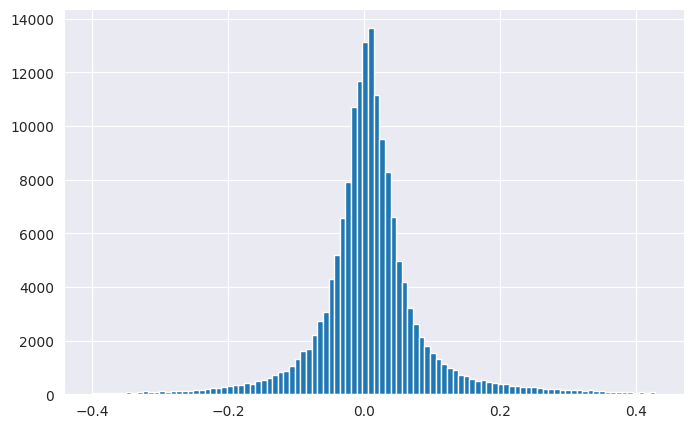

In [14]:
y.hist(bins=100, figsize=(8,5))
plt.show()


 mu = 0.01 and sigma = 0.08



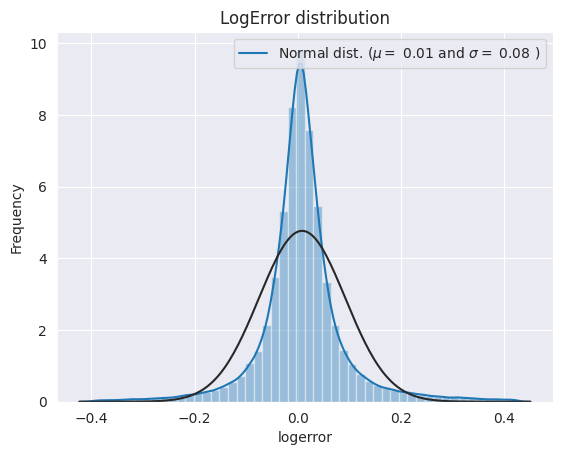

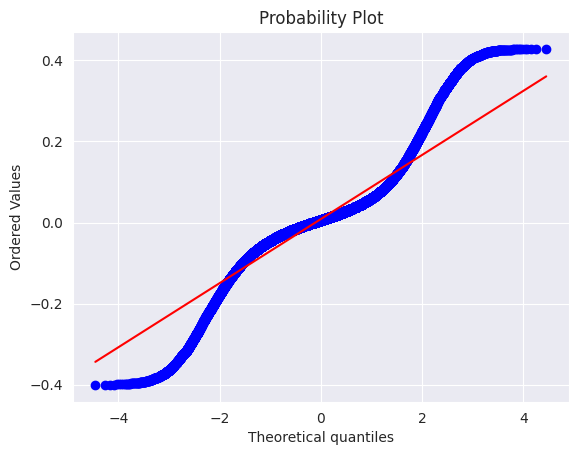

In [15]:
#Check the new distribution 
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogError distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

In [16]:
from zlib import crc32
from sklearn.model_selection import train_test_split 

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    
    train_set = data.loc[~in_test_set]
    test_set = data.loc[in_test_set]
    
    X_train = train_set.drop("logerror", axis=1)
    y_train = train_set["logerror"].copy()
    X_test = test_set.drop("logerror", axis=1)
    y_test = test_set["logerror"].copy()
    return X_train, X_test, y_train, y_test

X_other, X_test, y_other, y_test = split_train_test_by_id(housing, 0.000001, "parcelid")
print(f"Other Dataset Shape: {X_other.shape}; Test Dataset Shape: {X_test.shape}")

Other Dataset Shape: (164538, 59); Test Dataset Shape: (0, 59)


In [17]:
# Clear memory
del all_properties, housing; gc.collect()

0

In [18]:
X_train=X_other
y_train=y_other
all_data_na = (X_train.isnull().sum() / len(X_train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data[:35]

,Missing Ratio
buildingclasstypeid,99.986
finishedsquarefeet13,99.957
basementsqft,99.947
storytypeid,99.947
yardbuildingsqft26,99.903
fireplaceflag,99.763
architecturalstyletypeid,99.717
typeconstructiontypeid,99.686
finishedsquarefeet6,99.543
decktypeid,99.235


In [19]:
print ("Features with one unique value!!")
exclude_unique = []
for c in X_train.columns:
    num_uniques = len(X_train[c].unique())
    if X_train[c].isnull().sum() != 0:
        num_uniques -= 1
    if num_uniques == 1:
        exclude_unique.append(c)
print(exclude_unique)

Features with one unique value!!
['decktypeid', 'hashottuborspa', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'storytypeid', 'fireplaceflag', 'taxdelinquencyflag']


In [20]:
# Training data copy to test individual pipelines 
X_temp = X_train.copy()

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop):
        self.features_to_drop = features_to_drop
    def fit(self, X, y=None):
        return self  # nothing else to do 
    def transform(self, X): 
        updated_X = X.drop(self.features_to_drop, axis=1)
        return updated_X
    
# Drop features
lin_reg_drop_vars = ["finishedsquarefeet13", "finishedsquarefeet15", "finishedfloor1squarefeet", "finishedsquarefeet50",
             "storytypeid", "architecturalstyletypeid", "buildingclasstypeid", "typeconstructiontypeid", "finishedsquarefeet6",
             "pooltypeid10", "pooltypeid7", "hashottuborspa", "fireplaceflag", "threequarterbathnbr", "calculatedbathnbr",
             "fullbathcnt", "numberofstories", "rawcensustractandblock", "censustractandblock",
             "finishedsquarefeet12", "taxvaluedollarcnt", "taxamount", "assessmentyear", "roomcnt",
             "propertyzoningdesc", "regionidneighborhood", "regionidzip", "taxdelinquencyyear",
             "propertycountylandusecode", "regionidcity", "parcelid", "basementsqft", "yardbuildingsqft26", "transactiondate"
            ]

# Sample code to test pipeline 
feat_dropper = FeatureDropper(features_to_drop=lin_reg_drop_vars)
X_temp = feat_dropper.fit_transform(X_temp)

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [23]:
# Impute 0
impute_0_vars = ["yardbuildingsqft17", "fireplacecnt", "poolcnt", "garagecarcnt", "garagetotalsqft",
                 "pooltypeid2", "poolsizesum", "decktypeid", "taxdelinquencyflag"]

# Impute mode
impute_mode_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "unitcnt", "fips", 
                    "propertylandusetypeid", "regionidcounty", "yearbuilt"] 

# Impute median 
impute_median_vars = ["buildingqualitytypeid", "lotsizesquarefeet", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet",
                      "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt", "latitude", "longitude"]

univariate_impute_pipe = ColumnTransformer([
        ("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
        ("impute_mode", SimpleImputer(strategy="most_frequent"), impute_mode_vars),
        ("impute_median", SimpleImputer(strategy="median"), impute_median_vars),
    ],
    remainder='passthrough'
)

# Sample code to test pipeline [ONLY RUN ONE OF UNIVARIATE OR MULTIVARIATE PIPELINES]
X_temp = univariate_impute_pipe.fit_transform(X_temp)

In [24]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

cat_impute_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
numeric_impute_vars = ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet",
                  "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt",
                  "poolsizesum", "unitcnt", "yardbuildingsqft17", "yearbuilt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]

multivariate_impute_pipe = ColumnTransformer([
        ("impute_cats", SimpleImputer(strategy="constant", fill_value='missing'), cat_impute_vars),
        ("impute_num", IterativeImputer(estimator=RandomForestRegressor(n_estimators=1, max_depth=30, min_samples_leaf=32), random_state=0, max_iter=1), numeric_impute_vars),
    ],
    remainder='passthrough'
)

# Sample code to test pipeline [ONLY RUN ONE OF UNIVARIATE OR MULTIVARIATE PIPELINES]
# X_temp = multivariate_impute_pipe.fit_transform(X_temp)

In [25]:
class ColumnNamesAppender(BaseEstimator, TransformerMixin):
    """
    Takes a Column Transformer pipeline as an input along with the Numpy Array 
    to output the DataFrame with column names appended to it. 
    """
    def __init__(self, column_transformer, orig_columns, num_transformers):
        self.column_transformer = column_transformer
        self.orig_columns = orig_columns
        self.num_transformers = num_transformers
    def fit(self, X, y=None):
        return self  # nothing else to do 
    def transform(self, X): 
        X_column_names = self.get_columns_from_transformer(self.column_transformer, self.orig_columns, self.num_transformers)
        
        # Create dataframe from numpy array and column names 
        X = pd.DataFrame(X, columns=X_column_names)
        return X 
    
    @staticmethod
    def get_columns_from_transformer(column_transformer, input_colums, num_transformers):    
        col_name = []
        
        for transformer_in_columns in column_transformer.transformers_: #the last transformer is ColumnTransformer's 'remainder'
            raw_col_name = transformer_in_columns[2]
            if isinstance(transformer_in_columns[1],Pipeline): 
                transformer = transformer_in_columns[1].steps[-1][1]
            else:
                transformer = transformer_in_columns[1]
            try:
                names = transformer.get_feature_names([raw_col_name])
            except AttributeError: # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
            if isinstance(names,np.ndarray): 
                col_name += names.tolist()
            elif isinstance(names,list):
                col_name += names    
            elif isinstance(names,str):
                col_name.append(names)

        return col_name


# Code to test pipeline (using imputation pipeline as sample ColumnTransformer pipeline)
# TODO: Currently unable to handle columns that are passed through remainder 
column_appender = ColumnNamesAppender(univariate_impute_pipe, orig_columns=X_train.columns, num_transformers=3)
X_temp = column_appender.fit_transform(X_temp)

In [26]:
# Check if still missing values
all_data_na = (X_temp.isnull().sum() / len(X_temp)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:40]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head

<bound method NDFrame.head of Empty DataFrame
Columns: [Missing Ratio]
Index: []>

In [27]:
convert_to_int = ["yearbuilt"] 
convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
convert_to_float= ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet",
                  "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt",
                  "poolsizesum", "unitcnt", "yardbuildingsqft17",
                  "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]

class ConvertFeatureType(BaseEstimator, TransformerMixin): 
    def __init__(self, convert_to_int=[], convert_to_bool=[], convert_to_string=[], convert_to_float=[]):
        self.convert_to_int = convert_to_int
        self.convert_to_bool = convert_to_bool
        self.convert_to_string = convert_to_string
        self.convert_to_float = convert_to_float
        self.features = {"int": convert_to_int, "float": convert_to_float, "boolean": convert_to_bool, "str": convert_to_string}
        
    def fit(self, X, y=None): 
        return self  # Nothing else to do 
    
    def transform(self, X): 
        self.map_bool_features(X)        
        for data_type in self.features.keys(): 
            X = self.convert_feature_types(X, data_type)
        return X 
    
    def map_bool_features(self, X): 
        """Convert all non null values to True in bool features prior to changing type to Boolean."""
        for var in self.convert_to_bool:
            X[var][X[var].notnull()] = True
    
    def convert_feature_types(self, X, data_type): 
        for var in self.features[data_type]: 
            X[var] = X[var].astype(data_type) 
        return X
    
# # Code to test pipeline
feature_type_changer = ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, convert_to_float=convert_to_float)
X_temp = feature_type_changer.fit_transform(X_temp)

In [28]:
class ConvertToType(BaseEstimator, TransformerMixin): 
    '''
    Variation of pipeline above to convert ALL colummns to specific type.
    Handy for algorithms such as XGBoost which expect all features to not be object type. 
    '''
    def __init__(self, var_type, vars_to_convert=None):
        self.var_type = var_type
        self.vars_to_convert = vars_to_convert
        
    def fit(self, X, y=None): 
        return self  # Nothing else to do 
    
    def transform(self, X): 
        if self.vars_to_convert: 
            for col in self.vars_to_convert: 
                X[col] = X[col].astype(self.var_type) 
        else: 
            for col in X.columns: 
                X[col] = X[col].astype(self.var_type)     
        return X
      
# Code to test pipeline
# convert_to_float = ConvertToType(var_type='float', vars_to_convert=sample_vars)
# X_temp = convert_to_float.fit_transform(X_temp)

In [29]:
class CreateDateFeatures(BaseEstimator, TransformerMixin):
    """
    Creates simple date features by extracting the information from `transactiondate` 
    """
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        dt = pd.to_datetime(X['transactiondate']).dt
        X['transaction_year'] = (dt.year).astype('category')
        X['transaction_month'] = ((dt.year - 2016)*12 + dt.month).astype('category')
        X['transaction_day'] = dt.day
        X['transaction_quarter'] = ((dt.year - 2016)*4 + dt.quarter).astype('category')
        X = X.drop(['transactiondate'], axis=1)
    
        return X
    
# Code to test pipeline
# date_feat_creator = CreateDateFeatures()
# X_temp = date_feat_creator.fit_transform(X_temp)

In [30]:
from datetime import date

class CreateYearFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new features converting dates into years from present. 
    Eg: 1989 is converted into present_year(2021) - 1989 which is 32. 
    """
    def __init__(self, date_features):
        self.date_features = date_features
        self.current_year = date.today().year
    
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        for var in self.date_features.keys(): 
            new_var_name = self.date_features[var]
            X[new_var_name] = self.current_year - X[var]
            X[new_var_name] = X[new_var_name].astype('float') 
            
            # Drop old feature
            X.drop(var, axis=1, inplace=True)
        return X
    
# Date features
date_features = {"yearbuilt": "house_age"}

# Code to test pipeline
year_feat_creator = CreateYearFeatures(date_features=date_features)
X_temp = year_feat_creator.fit_transform(X_temp)

In [31]:
class CreateDerivedFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new features by combining existing variables 
    """
    def __init__(self):
        return None # nothing else to do 
    
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        # Average Size Features 
        X['avg_garage_size'] = X['garagetotalsqft'] / X['garagecarcnt']
        X['property_tax_per_sqft'] = X['taxamount'] / X['calculatedfinishedsquarefeet']
        
        # Average area in sqft per room
        mask = (X.roomcnt >= 1)  # avoid dividing by zero
        X.loc[mask, 'avg_area_per_room'] = X.loc[mask, 'calculatedfinishedsquarefeet'] / X.loc[mask, 'roomcnt']
        
        # Derived Room Count
        X['derived_room_cnt'] = X['bedroomcnt'] + X['bathroomcnt']
        
        # Use the derived room_cnt to calculate the avg area again
        mask = (X.derived_room_cnt >= 1)
        X.loc[mask,'derived_avg_area_per_room'] = X.loc[mask,'calculatedfinishedsquarefeet'] / X.loc[mask,'derived_room_cnt']
        
        # Rotated Coordinates
        X['location_1'] = X['latitude'] + X['longitude']
        X['location_2'] = X['latitude'] - X['longitude']
        X['location_3'] = X['latitude'] + 0.5 * X['longitude']
        X['location_4'] = X['latitude'] - 0.5 * X['longitude']
        
        # 'finished_area_sqft' and 'total_area' cover only a strict subset of 'finished_area_sqft_calc' in terms of 
        # non-missing values. Also, when both fields are not null, the values are always the same.
        # So we can probably drop 'finished_area_sqft' and 'total_area' since they are redundant
        # If there're some patterns in when the values are missing, we can add two isMissing binary features
        X['missing_finished_area'] = X['finishedsquarefeet12'].isnull().astype(float)
        X['missing_total_area'] = X['finishedsquarefeet15'].isnull().astype(float)
        X = X.drop(['finishedsquarefeet12', 'finishedsquarefeet15'], axis=1)
        X['missing_bathroom_cnt_calc'] = X['calculatedbathnbr'].isnull().astype(float)
        X = X.drop(['calculatedbathnbr'], axis=1)
        
        return X
    
# Code to test pipeline
# derived_feat_creator = CreateDerivedFeatures()
# X_temp = derived_feat_creator.fit_transform(X_temp)

In [32]:
class CreateAggregatedFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new features by combining existing variables 
    """
    def __init__(self, group_col, agg_cols):
        self.group_col = group_col
        self.agg_cols = agg_cols
    
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        group_col = self.group_col
        X[group_col + '-groupcnt'] = X[group_col].map(X[group_col].value_counts())
        
        new_columns = []  # New feature columns added to the DataFrame
        for col in self.agg_cols:
            aggregates = X.groupby(group_col, as_index=False)[col].agg([np.mean])
            aggregates.columns = [group_col + '-' + col + '-' + s for s in ['mean']]
            new_columns += list(aggregates.columns)
            X = X.merge(how='left', right=aggregates, on=group_col)

        for col in self.agg_cols:
            mean = X[group_col + '-' + col + '-mean']
            diff = X[col] - mean

            X[group_col + '-' + col + '-' + 'diff'] = diff
            if col != 'yearbuilt':
                X[group_col + '-' + col + '-' + 'percent'] = diff / mean

        # Set the values of the new features to NaN if the groupcnt is too small (prevent overfitting)
        threshold = 100
        X[new_columns] = X.loc[X[group_col + '-groupcnt'] < threshold, new_columns] = np.nan

        # Drop the mean features which are not as useful
        X = X.drop([group_col+'-'+col+'-mean' for col in self.agg_cols], axis=1)

        return X
    
# Code to test pipeline
# aggregated_feat_creator = CreateAggregatedFeatures(group_col=group_col, agg_cols=agg_cols)
# X_temp = aggregated_feat_creator.fit_transform(X_temp)

In [33]:
class FeatureEncoderAndScaler(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_encode=None, features_to_scale=None, numeric_types=["float"]):
        self.features_to_encode = features_to_encode
        self.features_to_scale = features_to_scale
        self.numeric_types = numeric_types
        self.feature_encoder_and_scaler = None
        
    def fit(self, X, y=None):
        if not self.features_to_encode:
            self.features_to_encode = X.select_dtypes(include = ["object"]).columns 
        if not self.features_to_scale:
            self.features_to_scale = X.select_dtypes(include = self.numeric_types).columns   
        
        feature_encoder_scaler = ColumnTransformer([
            ("ohe_cats", OneHotEncoder(handle_unknown='ignore', sparse=False), self.features_to_encode),
            ("num_scaler", RobustScaler(), self.features_to_scale),
        ],
            remainder='passthrough',
#             verbose_feature_names_out='False'    # To turn off prefixing of transformer name to feature
        )
                    
        self.feature_encoder_scaler = feature_encoder_scaler.fit(X)
        return self   
    
    def transform(self, X): 
        # OneHotEncoder returns numpy array which is converted to dataframe
        X_np = self.feature_encoder_scaler.transform(X)
        X = pd.DataFrame(
            X_np, 
            columns=self.feature_encoder_scaler.get_feature_names_out()
        )
        X = self.convert_feature_types(X)
        
        return X
    
    def convert_feature_types(self, X):
        """Convert feature types to object, float, bool based on the column name. 
        Columns with `ohe_cats` are object, `num_scaler` are float, `remainder` are bool"""
        for column in X:
            if 'ohe_cats' in column:
                X[column] = X[column].astype("object") 
            elif 'num_scaler' in column: 
                X[column] = X[column].astype("float") 
            elif 'remainder' in column: 
                X[column] = X[column].astype("boolean") 
        return X 
        

# Code to test pipeline
# cat_features = X_test.select_dtypes(include = ["object"]).columns            # optional as encoder automatically detects relevant features     
# feature_encoder_scaler = FeatureEncoderAndScaler(features_to_encode=cat_features)
feature_encoder_scaler = FeatureEncoderAndScaler()
X_temp = feature_encoder_scaler.fit_transform(X_temp)

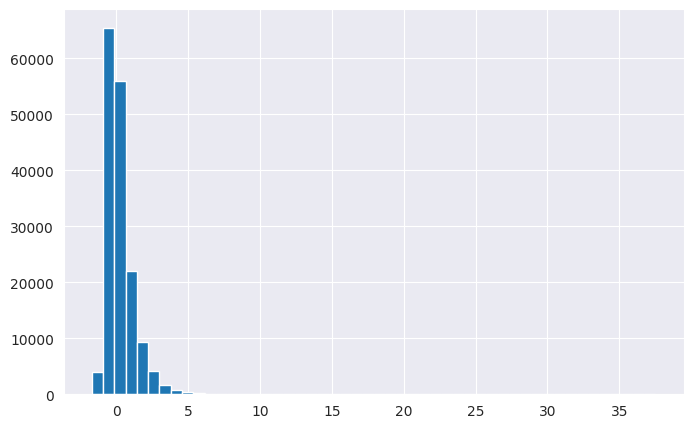

In [34]:
# Sample plot histogram to check standardized variable
X_temp.num_scaler__calculatedfinishedsquarefeet.hist(bins=50, figsize=(8,5))
plt.show()

<AxesSubplot:>

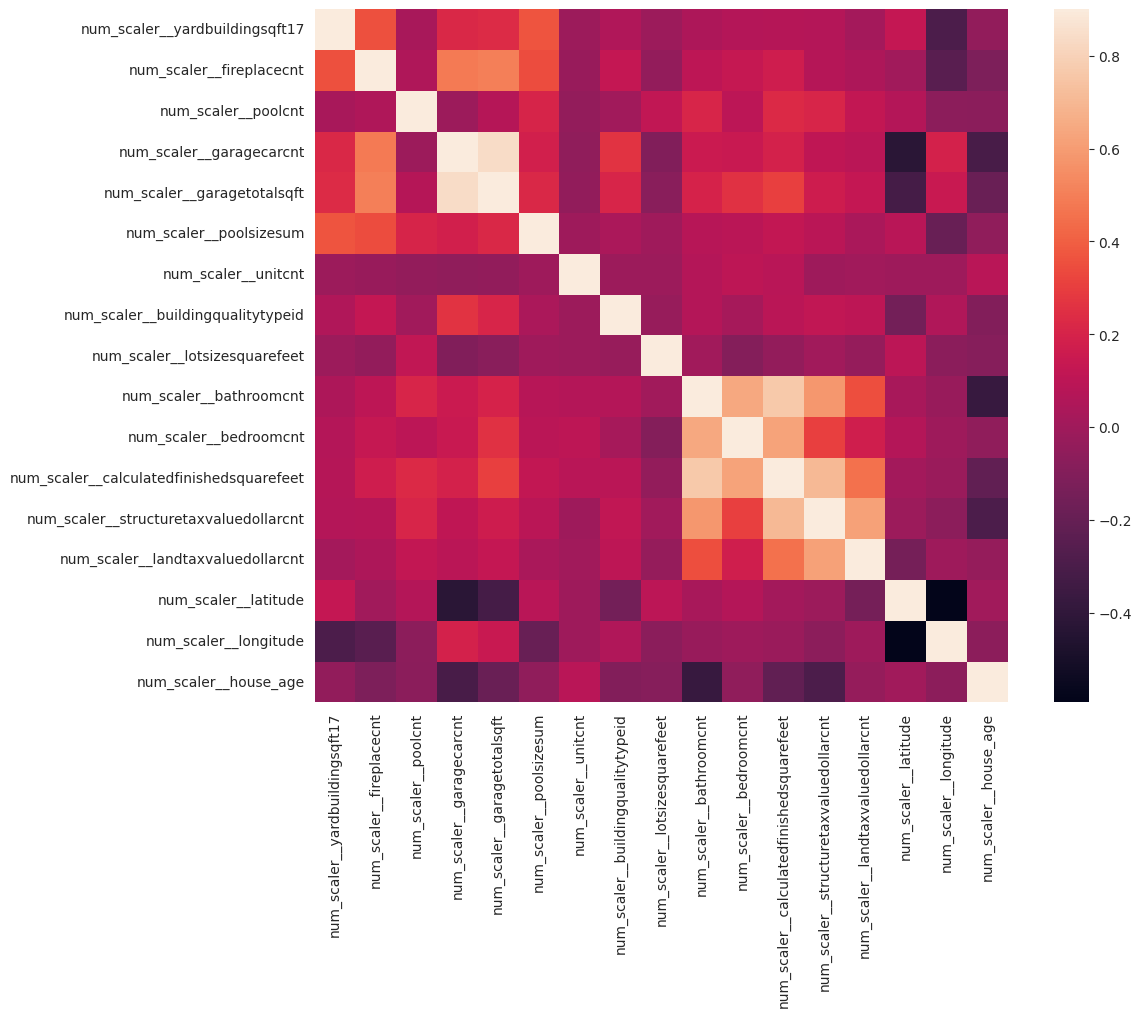

In [35]:
#Correlation map to see how features are correlated with SalePrice
corrmat = X_temp.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [36]:
# Find most important features relative to target (Take absolute value)
print("Find most important features relative to target")
corr_df = X_temp.copy()
corr_df["logerror"] = y_train.values
corr = corr_df.corr()
most_corr_feat = corr.logerror.abs().sort_values(ascending=False)[1:9].index
most_corr_feat

Find most important features relative to target


Index(['num_scaler__calculatedfinishedsquarefeet', 'num_scaler__bathroomcnt',
       'num_scaler__bedroomcnt', 'num_scaler__structuretaxvaluedollarcnt',
       'num_scaler__house_age', 'num_scaler__garagetotalsqft',
       'num_scaler__garagecarcnt', 'num_scaler__poolcnt'],
      dtype='object')

In [37]:
class CreatePolynomialFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new polynomial features using the 10 most important features relative to the target. 
    3 new polynomial variables for each of the existing features: squared, cubed, sqrt. 
    """
    def __init__(self, most_imp_feat):
        self.most_imp_feat = most_imp_feat
    
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        
        for var in self.most_imp_feat: 
            # New var names 
            s2_var_name = var + '-s2'
            s3_var_name = var + '-s3'
            sq_var_name = var + '-sqrt'
            
            # Create features 
            X[s2_var_name] = X[var] ** 2 
            X[s3_var_name] = X[var] ** 3 
            X[sq_var_name] = np.sqrt(X[var] + abs(min(X[var])))  # Translate feature to ensure min value is 0 before sqrt 
            
        return X
    
# Code to test pipeline
poly_feat_creator = CreatePolynomialFeatures(most_corr_feat)
X_temp = poly_feat_creator.fit_transform(X_temp)

In [38]:
# Code to detect any skewed features 
numeric_feats = X_temp.dtypes[X_temp.dtypes == 'float'].index
skewed_feats = X_temp[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats[:20]

num_scaler__calculatedfinishedsquarefeet-s3   295.373
num_scaler__unitcnt                           195.062
num_scaler__structuretaxvaluedollarcnt-s3     180.584
num_scaler__bathroomcnt-s3                    131.239
num_scaler__garagetotalsqft-s3                105.544
num_scaler__calculatedfinishedsquarefeet-s2    97.071
num_scaler__garagecarcnt-s3                    86.323
num_scaler__structuretaxvaluedollarcnt-s2      85.271
num_scaler__bedroomcnt-s3                      43.881
num_scaler__lotsizesquarefeet                  27.178
num_scaler__garagetotalsqft-s2                 26.826
num_scaler__bathroomcnt-s2                     17.506
num_scaler__garagecarcnt-s2                    14.991
num_scaler__bedroomcnt-s2                      13.892
num_scaler__yardbuildingsqft17                 12.062
num_scaler__landtaxvaluedollarcnt              11.817
num_scaler__poolsizesum                        10.746
num_scaler__structuretaxvaluedollarcnt          9.293
num_scaler__house_age-s3    

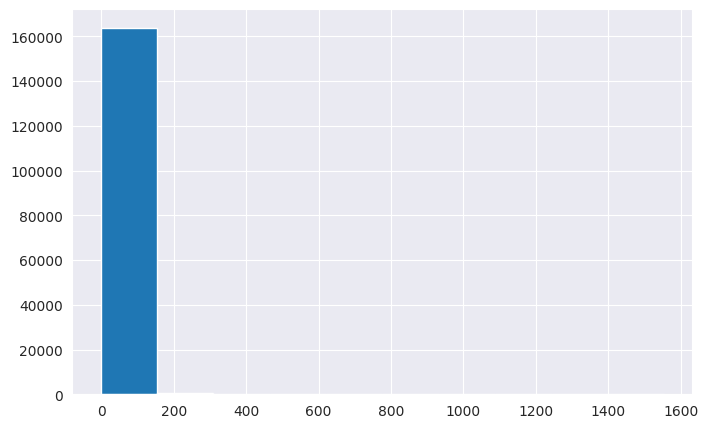

In [39]:
X_temp.num_scaler__lotsizesquarefeet.hist(bins=10, figsize=(8,5))
plt.show()

In [40]:
from datetime import date
from scipy.special import boxcox1p

class BoxCoxSkewedFeatures(BaseEstimator, TransformerMixin):
    """
    Performs Box-Cox tranformation on all numerical variables with skewness
    above a certain threshold. 
    """
    def __init__(self, skewness_thres=0.75):
        self.skewness_thres = skewness_thres
    def fit(self, X, y=None):
        return self  # nothing else to do 
    def transform(self, X): 
        numeric_feats = X.dtypes[X.dtypes == 'float'].index
        skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        
        skewed_feats = skewed_feats[abs(skewed_feats) > self.skewness_thres].index
        
        # Apply box-cox to each variable 
        lam = 0.18
        for feat in skewed_feats:
            X[feat] = X[feat] + abs(min(X[feat]))       # Translate feature to ensure minimum value is 0 
            X[feat] = boxcox1p(X[feat], lam)
        return X
    

# # Code to test pipeline
skew_transformer = BoxCoxSkewedFeatures()
X_temp = skew_transformer.transform(X_temp)

In [41]:
# Check skewed features after box-cox transformation
numeric_feats = X_temp.dtypes[X_temp.dtypes == 'float'].index
skewed_feats = X_temp[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats[:20]

num_scaler__poolsizesum                       9.430
num_scaler__structuretaxvaluedollarcnt-s3     6.944
num_scaler__calculatedfinishedsquarefeet-s3   6.713
num_scaler__unitcnt                           6.434
num_scaler__yardbuildingsqft17                5.780
num_scaler__structuretaxvaluedollarcnt-s2     4.710
num_scaler__bathroomcnt-s3                    4.000
num_scaler__garagecarcnt-s3                   3.511
num_scaler__bedroomcnt-s2                     3.454
num_scaler__calculatedfinishedsquarefeet-s2   3.333
num_scaler__lotsizesquarefeet                 3.146
num_scaler__bedroomcnt-s3                     3.122
num_scaler__fireplacecnt                      2.993
num_scaler__bathroomcnt-s2                    2.477
num_scaler__structuretaxvaluedollarcnt        1.815
num_scaler__landtaxvaluedollarcnt             1.785
num_scaler__garagecarcnt-s2                   1.741
num_scaler__poolcnt-sqrt                      1.472
num_scaler__poolcnt-s3                        1.472
num_scaler__

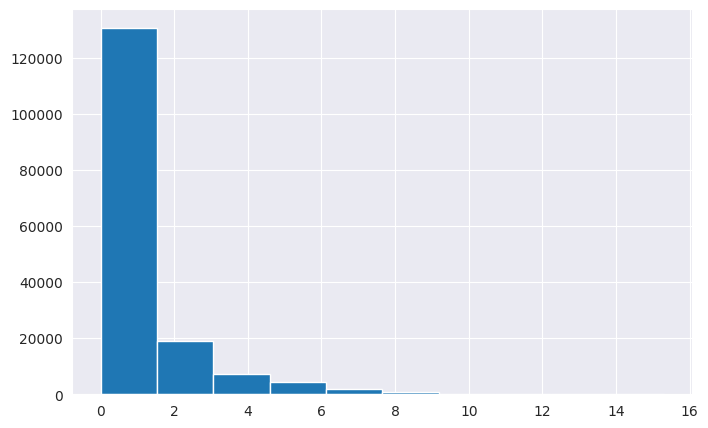

In [42]:
X_temp.num_scaler__lotsizesquarefeet.hist(bins=10, figsize=(8,5))
plt.show()

In [43]:
X_temp.head()

,ohe_cats__pooltypeid2_0,ohe_cats__pooltypeid2_1.0,ohe_cats__decktypeid_0,ohe_cats__decktypeid_66.0,ohe_cats__taxdelinquencyflag_0,ohe_cats__taxdelinquencyflag_Y,ohe_cats__airconditioningtypeid_1.0,ohe_cats__airconditioningtypeid_11.0,ohe_cats__airconditioningtypeid_13.0,ohe_cats__airconditioningtypeid_3.0,ohe_cats__airconditioningtypeid_5.0,ohe_cats__airconditioningtypeid_9.0,ohe_cats__heatingorsystemtypeid_1.0,ohe_cats__heatingorsystemtypeid_10.0,ohe_cats__heatingorsystemtypeid_11.0,ohe_cats__heatingorsystemtypeid_12.0,ohe_cats__heatingorsystemtypeid_13.0,ohe_cats__heatingorsystemtypeid_14.0,ohe_cats__heatingorsystemtypeid_18.0,ohe_cats__heatingorsystemtypeid_2.0,ohe_cats__heatingorsystemtypeid_20.0,ohe_cats__heatingorsystemtypeid_24.0,ohe_cats__heatingorsystemtypeid_6.0,ohe_cats__heatingorsystemtypeid_7.0,ohe_cats__fips_6037.0,ohe_cats__fips_6059.0,ohe_cats__fips_6111.0,ohe_cats__propertylandusetypeid_246.0,ohe_cats__propertylandusetypeid_247.0,ohe_cats__propertylandusetypeid_248.0,ohe_cats__propertylandusetypeid_260.0,ohe_cats__propertylandusetypeid_261.0,ohe_cats__propertylandusetypeid_263.0,ohe_cats__propertylandusetypeid_264.0,ohe_cats__propertylandusetypeid_265.0,ohe_cats__propertylandusetypeid_266.0,ohe_cats__propertylandusetypeid_267.0,ohe_cats__propertylandusetypeid_269.0,ohe_cats__propertylandusetypeid_275.0,ohe_cats__propertylandusetypeid_31.0,ohe_cats__regionidcounty_1286.0,ohe_cats__regionidcounty_2061.0,ohe_cats__regionidcounty_3101.0,num_scaler__yardbuildingsqft17,num_scaler__fireplacecnt,num_scaler__poolcnt,num_scaler__garagecarcnt,num_scaler__garagetotalsqft,num_scaler__poolsizesum,num_scaler__unitcnt,num_scaler__buildingqualitytypeid,num_scaler__lotsizesquarefeet,num_scaler__bathroomcnt,num_scaler__bedroomcnt,num_scaler__calculatedfinishedsquarefeet,num_scaler__structuretaxvaluedollarcnt,num_scaler__landtaxvaluedollarcnt,num_scaler__latitude,num_scaler__longitude,num_scaler__house_age,num_scaler__calculatedfinishedsquarefeet-s2,num_scaler__calculatedfinishedsquarefeet-s3,num_scaler__calculatedfinishedsquarefeet-sqrt,num_scaler__bathroomcnt-s2,num_scaler__bathroomcnt-s3,num_scaler__bathroomcnt-sqrt,num_scaler__bedroomcnt-s2,num_scaler__bedroomcnt-s3,num_scaler__bedroomcnt-sqrt,num_scaler__structuretaxvaluedollarcnt-s2,num_scaler__structuretaxvaluedollarcnt-s3,num_scaler__structuretaxvaluedollarcnt-sqrt,num_scaler__house_age-s2,num_scaler__house_age-s3,num_scaler__house_age-sqrt,num_scaler__garagetotalsqft-s2,num_scaler__garagetotalsqft-s3,num_scaler__garagetotalsqft-sqrt,num_scaler__garagecarcnt-s2,num_scaler__garagecarcnt-s3,num_scaler__garagecarcnt-sqrt,num_scaler__poolcnt-s2,num_scaler__poolcnt-s3,num_scaler__poolcnt-sqrt
0,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.575,1.062,1.215,0.000,1.153,0.703,0.667,0.718,-0.638,0.324,0.025,2.081,0.929,0.000,2.695,1.414,0.000,1.691,0.860,0.008,0.787,0.720,0.100,1.409,1.295,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.738,11.253,0.000,0.000,2.330,0.605,1.727,0.500,1.401,1.457,0.671,-0.977,1.014,-1.294,0.511,2.194,1.032,1.313,3.182,1.871,0.228,1.727,0.955,1.448,2.190,1.055,1.076,0.276,0.243,45.262,148.140,4.185,0.738,0.738,0.738,0.000,0.000,0.000
2,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000

In [44]:
# Clear memory
del X_temp; gc.collect()

13461

In [45]:
X_prepared = X_train.copy()


In [46]:
# Feature Dropper Pipeline
feature_dropper = FeatureDropper(features_to_drop=lin_reg_drop_vars)

# Convert Date Features Pipeline
year_feat_creator = CreateYearFeatures(date_features=date_features)

# Feature Encoding and Scaling Pipeline
feature_encoder_scaler = FeatureEncoderAndScaler()

# Transform Skewed Numerical Features Pipeline
skew_transformer = BoxCoxSkewedFeatures()

# Two versions below: Univariate Imputation and Multivariate Imputation - ONLY UNCOMMENT ONE SECTION
########################################### 
# 1) Univariate Imputation Pipeline

convert_to_bool = ["pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty"]
univariate_impute_pipe = ColumnTransformer([
        ("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
        ("impute_mode", SimpleImputer(strategy="most_frequent"), impute_mode_vars),
        ("impute_median", SimpleImputer(strategy="median"), impute_median_vars),
    ],
    remainder='passthrough'
)
col_name_appender = ColumnNamesAppender(univariate_impute_pipe, X_train.columns, num_transformers=3)
feature_type_changer = ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, 
                                          convert_to_float=convert_to_float, convert_to_bool=convert_to_bool)
poly_feat_creator = CreatePolynomialFeatures(most_corr_feat)


############################################
# 2) Multivariate Version

# convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"]
# multivariate_impute_pipe = ColumnTransformer([
#         ("impute_cats", SimpleImputer(strategy="constant", fill_value='missing'), cat_impute_vars),
#         ("impute_num", IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, max_depth=30, min_samples_leaf=32), random_state=0, max_iter=1), numeric_impute_vars),
#     ],
#     remainder='passthrough'
# )
# col_name_appender = ColumnNamesAppender(multivariate_impute_pipe, X_train.columns, num_transformers=3)
# feature_type_changer = ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, convert_to_float=convert_to_float)
# # most_corr_feat = list(map(lambda x: x.replace('num_scaler__',''), most_corr_feat))     # Clean up feature names by removing `num_scaler__`
# poly_feat_creator = CreatePolynomialFeatures(most_corr_feat)

In [47]:
lin_reg_preprocessor = Pipeline([
        ('feature_dropper', feature_dropper),
        ('univariate_impute_pipe', univariate_impute_pipe),
#         ('multivariate_impute_pipe', multivariate_impute_pipe),
        ('col_name_appender', col_name_appender),
        ('feature_type_changer', feature_type_changer),
        ('year_feat_creator', year_feat_creator),
        ('feature_encoder_scaler', feature_encoder_scaler),
        ('poly_feat_creator', poly_feat_creator),
        ('skew_transformer', skew_transformer),
    ])

data_prep_pipe = lin_reg_preprocessor.fit(X_prepared)
X_prepared = lin_reg_preprocessor.transform(X_prepared)

In [48]:
# X_test.shape
# X_prepared
y_train
y_train.to_csv('/home/wangyipeng/ysy/Fed-ReKD-dirs/process_dataset_y.csv')

In [49]:
X_prepared
# X_prepared.to_csv('/home/wangyipeng/ysy/Fed-ReKD-dirs/process_dataset_x.csv')
X_prepared.shape,y_train.shape

((164538, 81), (164538,))

In [50]:
from sklearn import set_config
set_config(display='diagram')
lin_reg_preprocessor

Pipeline(steps=[('feature_dropper',
                 FeatureDropper(features_to_drop=['finishedsquarefeet13',
                                                  'finishedsquarefeet15',
                                                  'finishedfloor1squarefeet',
                                                  'finishedsquarefeet50',
                                                  'storytypeid',
                                                  'architecturalstyletypeid',
                                                  'buildingclasstypeid',
                                                  'typeconstructiontypeid',
                                                  'finishedsquarefeet6',
                                                  'pooltypeid10', 'pooltypeid7',
                                                  'hashottuborspa',
                                                  'fireplaceflag',
                                                  'threequarterb...
                ('poly_feat_creator',
                 CreatePolynomialFeatures(most_imp_feat=Index(['num_scaler__calculatedfinishedsquarefeet', 'num_scaler__bathroomcnt',
       'num_scaler__bedroomcnt', 'num_scaler__structuretaxvaluedollarcnt',
       'num_scaler__house_age', 'num_scaler__garagetotalsqft',
       'num_scaler__garagecarcnt', 'num_scaler__poolcnt'],
      dtype='object'))),
                ('skew_transformer', BoxCoxSkewedFeatures())])

In [51]:
import random
input=random.randint(0,100000)
ans=[]
print(input)
for i in range(5,-1,-1):
    # print(i)
    ans.append(input//(10**i))
for i in range(5,1,-1):
    if i>=1:
        ans[i]-=ans[i-1]*10
new1=0
new2=0
print(ans)
ans=ans[::-1]
print(ans)
for i in range(6):
    if i<3:
        new1+=ans[i]*(10**i)
    else:
        new2+=ans[i]*(10**(i-3))
print(new2,',',new1)

68681
[0, 6, 8, 6, 8, 1]
[1, 8, 6, 8, 6, 0]
68 , 681
